In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
import pickle

import torchvision.models as models
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm.notebook import tqdm

In [2]:
images, labels = pickle.load(open('images_10_3.p', 'rb'))

In [3]:
images.shape

(11177, 100, 100, 3)

In [4]:
images[:, 0].mean(), images[:, 0].std()

(89.34033193164534, 49.83985561144281)

In [5]:
images.max(), images.min()

(255, 0)

In [6]:
# Split the classes in a balanced way

# Calculate the class frequencies
class_counts = Counter(labels)

# Calculate the number of samples in the train and test sets
num_samples = len(labels)
split_ratio = 0.8  # 80/20 train/test split
num_train_samples = int(num_samples * split_ratio)
num_test_samples = num_samples - num_train_samples

# Create a list of tuples, where each tuple contains the class label and the corresponding indices of the samples
label_indices = [(label, np.where(labels == label)[0]) for label in class_counts.keys()]

# Initialize the train and test sets
train_indices = []
test_indices = []

# Loop over the list of tuples
for label, indices in label_indices:
    # Calculate the number of samples for this class
    num_samples = len(indices)

    # Calculate the number of samples in the train and test sets for this class
    num_train_samples = int(num_samples * split_ratio)
    num_test_samples = num_samples - num_train_samples

    # Select the train and test indices for this class
    train_indices += random.sample(list(indices), num_train_samples)
    test_indices += [i for i in indices if i not in train_indices]

In [7]:
# check if they are balanced?

np.unique(labels[train_indices], return_counts=True), np.unique(labels[test_indices], return_counts=True)

((array([0, 1, 2, 3, 4]), array([7732,  354,  328,  222,  304])),
 (array([0, 1, 2, 3, 4]), array([1934,   89,   82,   56,   76])))

In [8]:
num_classes = len(np.unique(labels, return_counts=False))

In [9]:
# load a pretrained resnet152 from torchvision

model = models.__dict__["resnet152"](pretrained=True)
model.fc = nn.Linear(model.fc.weight.shape[1], num_classes)

In [10]:
# dataset class to create a data loader

class DDSM(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # images are in [0, 255] scale, normalize to [0, 1]
        image, label = self.images[idx]/255, self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image.float(), label

In [11]:
# function to test the model

def validation(model, val_dataloader, device="cpu"):
    
    total_loss = 0.0  # Initialize the loss sum to 0
    total_acc = 0.0   # Initialize the accuracy sum to 0
    num_samples = 0   # Initialize the number of samples processed to 0
    
    # Disable gradient calculation
    with torch.no_grad():
        
        # Loop over the validation data
        for inputs, labels in tqdm(val_dataloader):
            
            # Move the inputs and labels to the specified device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass through the model
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Calculate the accuracy
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).float().sum()
            
            total_loss += loss.item()
            total_acc += accuracy.item()
            num_samples += inputs.size(0)
    
    val_accuracy = total_acc / num_samples
    val_loss = total_loss / len(val_dataloader)
    
    return val_loss, val_accuracy

In [12]:
# training the model

def train(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=10, device='cpu'):
    
    # Move model to the specified device
    model.to(device)

    # Set the model to training mode
    model.train()
    
    training_losses = []
    training_accuracies = []
    
    val_losses = []
    val_accuracies = []

    # Loop over the number of epochs
    for epoch in range(num_epochs):

        total_loss = 0.0  # Initialize the loss sum to 0
        total_acc = 0.0   # Initialize the accuracy sum to 0
        num_samples = 0   # Initialize the number of samples processed to 0

        # Loop over the training data
        for inputs, labels in tqdm(train_dataloader):
            # Move the inputs and labels to the specified device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero out the gradients
            optimizer.zero_grad()

            # Forward pass through the model
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass through the model
            loss.backward()

            # Update the model parameters
            optimizer.step()

            # Calculate the accuracy
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).float().sum()

            total_loss += loss.item()
            total_acc += accuracy.item()
            num_samples += inputs.size(0)


        # Step the learning rate scheduler
        scheduler.step()

        training_losses.append(total_loss/len(train_dataloader))
        training_accuracies.append(total_acc/num_samples)
        
        model.eval()
        val_loss, val_accuracy = validation(model, val_dataloader, device=device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        model.train()
        
        # Print the epoch-level metrics
        print(f"{epoch+1}/{num_epochs} - train loss: {total_loss/len(train_dataloader):.4f} - train acc: {total_acc/num_samples:.4f}")
        print(f"{epoch+1}/{num_epochs} - val loss: {val_loss:.4f} - val acc: {val_accuracy:.4f}")
        
        
    return training_losses, training_accuracies, val_losses, val_accuracies


In [13]:
# define the image tranforms: 
# train: random flips and convert to tensor
# test: only convert to tensor
# resizing makes it large and does not fit into my GPU memory

train_list_transform = [transforms.ToTensor(), 
                        # transforms.Resize(244), 
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                       ]
val_list_transform = [transforms.ToTensor(),
                      # transforms.Resize(244),
                     ]

train_transform = transforms.Compose(train_list_transform)
val_transform = transforms.Compose(val_list_transform)

In [14]:
# create data loaders

batch_train = 32
batch_val = 32
train_dataset = DDSM(images[train_indices], labels[train_indices], train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_train, shuffle=True)
test_dataset = DDSM(images[test_indices], labels[test_indices], val_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_val, shuffle=False)

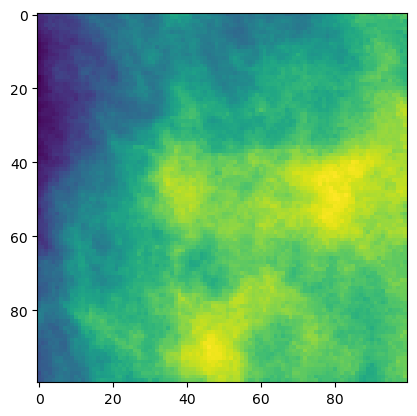

In [15]:
# example of an image

im = next(iter(train_loader))[0]
plt.imshow(im[0].permute(1,2,0).numpy()[...,0]);

In [16]:
# loss function to optimize
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
training_losses, training_accuracies, val_losses, val_accuracies = train(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=50, device='cuda')


  0%|          | 0/280 [00:00<?, ?it/s]

/home/masoud/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/70 [00:00<?, ?it/s]

1/50 - train loss: 0.5021 - train acc: 0.8617
1/50 - val loss: 0.8310 - val acc: 0.8435


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2/50 - train loss: 0.4788 - train acc: 0.8640
2/50 - val loss: 0.4480 - val acc: 0.8646


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

3/50 - train loss: 0.4339 - train acc: 0.8672
3/50 - val loss: 0.4255 - val acc: 0.8722


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

4/50 - train loss: 0.4187 - train acc: 0.8692
4/50 - val loss: 0.5205 - val acc: 0.8650


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

5/50 - train loss: 0.3934 - train acc: 0.8724
5/50 - val loss: 0.4770 - val acc: 0.8771


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

6/50 - train loss: 0.3643 - train acc: 0.8768
6/50 - val loss: 0.3763 - val acc: 0.8748


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

7/50 - train loss: 0.3514 - train acc: 0.8827
7/50 - val loss: 0.3515 - val acc: 0.8811


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

8/50 - train loss: 0.3333 - train acc: 0.8869
8/50 - val loss: 0.3606 - val acc: 0.8856


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

9/50 - train loss: 0.3349 - train acc: 0.8866
9/50 - val loss: 0.6105 - val acc: 0.8525


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

10/50 - train loss: 0.3425 - train acc: 0.8840
10/50 - val loss: 0.5481 - val acc: 0.8328


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

11/50 - train loss: 0.3113 - train acc: 0.8934
11/50 - val loss: 0.3073 - val acc: 0.8967


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

12/50 - train loss: 0.2900 - train acc: 0.9007
12/50 - val loss: 0.2862 - val acc: 0.9043


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

13/50 - train loss: 0.2795 - train acc: 0.9010
13/50 - val loss: 0.2824 - val acc: 0.9030


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

14/50 - train loss: 0.2706 - train acc: 0.9038
14/50 - val loss: 0.3369 - val acc: 0.8887


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

15/50 - train loss: 0.2637 - train acc: 0.9056
15/50 - val loss: 0.3927 - val acc: 0.8601


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

16/50 - train loss: 0.2557 - train acc: 0.9104
16/50 - val loss: 0.2701 - val acc: 0.9093


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

17/50 - train loss: 0.2536 - train acc: 0.9097
17/50 - val loss: 0.2780 - val acc: 0.9017


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

18/50 - train loss: 0.2478 - train acc: 0.9110
18/50 - val loss: 0.2570 - val acc: 0.9084


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

19/50 - train loss: 0.2453 - train acc: 0.9089
19/50 - val loss: 0.2962 - val acc: 0.9034


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

20/50 - train loss: 0.2395 - train acc: 0.9125
20/50 - val loss: 0.3429 - val acc: 0.8851


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

21/50 - train loss: 0.2317 - train acc: 0.9152
21/50 - val loss: 0.2491 - val acc: 0.9093


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

22/50 - train loss: 0.2214 - train acc: 0.9190
22/50 - val loss: 0.2491 - val acc: 0.9097


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

23/50 - train loss: 0.2202 - train acc: 0.9194
23/50 - val loss: 0.2502 - val acc: 0.9128


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

24/50 - train loss: 0.2235 - train acc: 0.9171
24/50 - val loss: 0.2474 - val acc: 0.9088


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

25/50 - train loss: 0.2177 - train acc: 0.9180
25/50 - val loss: 0.2458 - val acc: 0.9101


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

26/50 - train loss: 0.2186 - train acc: 0.9192
26/50 - val loss: 0.2474 - val acc: 0.9084


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

27/50 - train loss: 0.2136 - train acc: 0.9185
27/50 - val loss: 0.2479 - val acc: 0.9088


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

28/50 - train loss: 0.2129 - train acc: 0.9199
28/50 - val loss: 0.2486 - val acc: 0.9115


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

29/50 - train loss: 0.2136 - train acc: 0.9210
29/50 - val loss: 0.2459 - val acc: 0.9075


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

30/50 - train loss: 0.2116 - train acc: 0.9191
30/50 - val loss: 0.2437 - val acc: 0.9088


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

31/50 - train loss: 0.2052 - train acc: 0.9217
31/50 - val loss: 0.2452 - val acc: 0.9101


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

32/50 - train loss: 0.2087 - train acc: 0.9243
32/50 - val loss: 0.2525 - val acc: 0.9084


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

33/50 - train loss: 0.2064 - train acc: 0.9225
33/50 - val loss: 0.2448 - val acc: 0.9070


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

34/50 - train loss: 0.2056 - train acc: 0.9242
34/50 - val loss: 0.2432 - val acc: 0.9106


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

35/50 - train loss: 0.2080 - train acc: 0.9209
35/50 - val loss: 0.2454 - val acc: 0.9093


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

36/50 - train loss: 0.2101 - train acc: 0.9206
36/50 - val loss: 0.2454 - val acc: 0.9093


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

37/50 - train loss: 0.2080 - train acc: 0.9209
37/50 - val loss: 0.2481 - val acc: 0.9119


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

38/50 - train loss: 0.2127 - train acc: 0.9204
38/50 - val loss: 0.2465 - val acc: 0.9115


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

39/50 - train loss: 0.2089 - train acc: 0.9214
39/50 - val loss: 0.2456 - val acc: 0.9106


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

40/50 - train loss: 0.2079 - train acc: 0.9217
40/50 - val loss: 0.2449 - val acc: 0.9097


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

41/50 - train loss: 0.2105 - train acc: 0.9206
41/50 - val loss: 0.2453 - val acc: 0.9079


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

42/50 - train loss: 0.2081 - train acc: 0.9215
42/50 - val loss: 0.2452 - val acc: 0.9084


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

43/50 - train loss: 0.2058 - train acc: 0.9211
43/50 - val loss: 0.2466 - val acc: 0.9079


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

44/50 - train loss: 0.2063 - train acc: 0.9204
44/50 - val loss: 0.2447 - val acc: 0.9088


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

45/50 - train loss: 0.2063 - train acc: 0.9217
45/50 - val loss: 0.2465 - val acc: 0.9097


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

46/50 - train loss: 0.2095 - train acc: 0.9202
46/50 - val loss: 0.2433 - val acc: 0.9088


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

47/50 - train loss: 0.2087 - train acc: 0.9207
47/50 - val loss: 0.2463 - val acc: 0.9097


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

48/50 - train loss: 0.2071 - train acc: 0.9227
48/50 - val loss: 0.2472 - val acc: 0.9097


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

49/50 - train loss: 0.2079 - train acc: 0.9242
49/50 - val loss: 0.2455 - val acc: 0.9093


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

50/50 - train loss: 0.2090 - train acc: 0.9206
50/50 - val loss: 0.2490 - val acc: 0.9106


In [17]:
model.eval()
validation(model, test_loader, device="cuda")

  0%|          | 0/70 [00:00<?, ?it/s]

(0.24902760170017635, 0.9105945462673223)

In [18]:
torch.save(model, "DDSM_4classes_adam_0.001.pt")

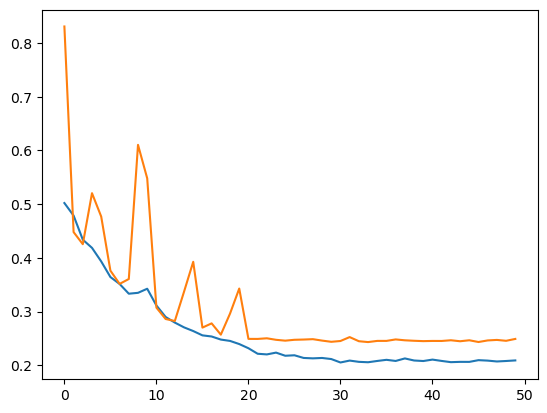

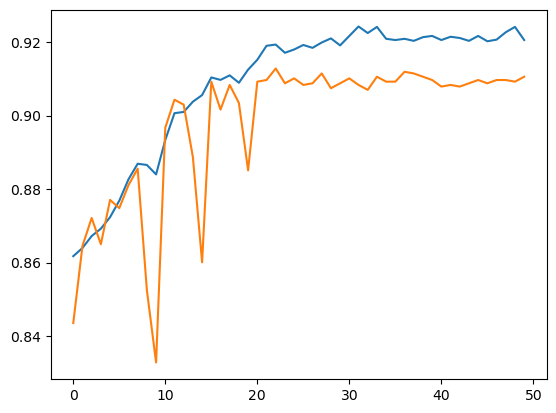

In [19]:
# plot the train / validation curve

plt.plot(training_losses)
plt.plot(val_losses)
plt.figure()
plt.plot(training_accuracies)
plt.plot(val_accuracies);